# Predicting Starcraft 2 players
[Kaggle Starcraft II Prediction Challenge](https://www.kaggle.com/c/insa-5if-2018)

## Initialisation
We will use Python3 with [Numpy](http://www.numpy.org/) for linear algebra, [Pandas](https://pandas.pydata.org/) for data processing and CSV files I/O, and [scikit-learn](https://scikit-learn.org/stable/) for predictions. The environment is defined by the [Kaggle Python docker image](https://github.com/kaggle/docker-python).

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from pandas.plotting import parallel_coordinates,scatter_matrix
import seaborn as sns
import os
import matplotlib.pyplot as plt
import copy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

## Important Variables

Some of these variables are useful in order to be sure that we get what we need, and making our code easier to modify.

In [2]:
#To be sure that we get all the right keys
CSV_KEYS = ['id', 'class']
for i in range(10):
    CSV_KEYS.append('hotkey' + str(i))

#Define map class->value
CLASSES = {}

#Zerg -> 0
#Protoss -> 1
#Terran -> 2
CLASSES['Zerg'] = 0
CLASSES['Protoss'] = 1
CLASSES['Terran'] = 2

#Define Paths
OUTPUT = '../data/output'
OUTPUT_SUB = OUTPUT
OUTPUT_CHARTS = OUTPUT + '/charts/'
INPUT = '../data/input'
INPUT_TRAIN = INPUT + '/TRAIN.CSV'
INPUT_TEST = INPUT + '/TEST.CSV'
INPUT_TRAIN_LONG = INPUT + '/TRAIN_LONG.CSV'

## Reading Data

Lets get the data to analyze it. The next function is usefull to get csv data as list.

In [3]:
import csv
from collections import defaultdict

def get_train_data(csv_file=INPUT_TRAIN):    
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []
        ids = []

        for row in cvs_reader:

            ids.append(row[0])
            train_dict = defaultdict(int)
            train_dict['id'] = row[0]
            train_dict['class'] = CLASSES[row[1]]

            t = 0
            for i in range(1, len(row)-2):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    train_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(train_dict)
        return (data, ids)
    
def get_test_data(csv_file=INPUT_TEST):    
    with open(csv_file, newline='') as csv_text:
        cvs_reader = csv.reader(csv_text, delimiter=',')
        data = []

        for row in cvs_reader:
            train_dict = defaultdict(int)
            train_dict['class'] = CLASSES[row[0]]
            t = 0
            for i in range(1, len(row)-1):
                if 'hotkey' in row[len(row)-i] and t != 0:
                    train_dict[row[len(row)-i][:-1]] += 1/t
                if 't' in row[len(row)-i][0] and t==0:
                    t = int(row[len(row)-i][1:])
            data.append(train_dict)
        return data   

Now we have **data**, which contains all matchs information, and **ids**, which contains only the ids we are interested on. It is time to pass it to a DataFrame for future work.

In [4]:
data, ids = get_train_data()
df = pd.DataFrame(data, columns=CSV_KEYS) 
print('Shape of the dataset: ' + str(df.shape))
df.sample(n=3).fillna(0)

Shape of the dataset: (3052, 12)


,id,class,hotkey0,hotkey1,hotkey2,hotkey3,hotkey4,hotkey5,hotkey6,hotkey7,hotkey8,hotkey9
115,http://eu.battle.net/sc2/en/profile/1058669/1/...,2,0.010976,0.792073,0.138415,0.073171,0.678049,0.022561,0.000000,0.118293,0.003659,0.004268
2046,http://eu.battle.net/sc2/en/profile/3311551/1/...,0,0.160494,0.088066,0.551440,0.117695,0.183539,0.679835,0.204938,0.060082,0.003292,0.001646
1345,http://kr.battle.net/sc2/en/profile/2345126/1/...,0,0.000000,0.304276,0.220724,0.171053,0.159868,0.062829,0.018421,0.000000,0.082237,0.000000


# EDA (Exploratory Data Analysis) 

## Number of games of each player

In [5]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=True).sample(n=5)

,id,count
6,http://eu.battle.net/sc2/en/profile/1430346/1/...,11
172,http://us.battle.net/sc2/en/profile/4580957/1/...,4
106,http://kr.battle.net/sc2/en/profile/2343733/1/...,23
194,http://xx.battle.net/sc2/en/profile/407/1/NaNiwa/,4
117,http://kr.battle.net/sc2/en/profile/2344230/1/...,20


We can observe that there is not a good distribution in terms of quantity of matchs per gamer. While some of them have just played 4, others have 50 registered.
This problem could be alleviate using over/under-sampling tools, like SMOTE or ADASYN.

Lets check how is the distribution of matchs of the whole sample.

In [6]:
df.groupby('id').id.count().reset_index(name='count').sort_values('count',ascending=False).describe()

,count
count,200.00000
mean,15.26000
std,10.41464
min,4.00000
25%,7.00000
50%,12.00000
75%,20.00000
max,58.00000


This reinforce our observetion, as the standar deviation is of 10, and given that our maximum value is almost 60, we have a variance of data that represents about a sixth of the range.
We can also notice that most of our players don't have more than 20 games registered for each other.

## Number of players

How many players do we have?

In [7]:
nb_joueur = list(dict.fromkeys(ids))
print(len(nb_joueur))

200


We can visualize what these players look like.

In [8]:
nb_joueur = list(dict.fromkeys(ids))
print(nb_joueur[0] + '\n' + nb_joueur[1])

http://eu.battle.net/sc2/en/profile/4234852/1/First/
http://eu.battle.net/sc2/en/profile/3074362/1/Stardust/


## Races's distribution

Now we try to understand how races influence players. 
1. Are all races chosen in an equally distribution?
2. Do gamers eventually change the class they use?

1    1210
0    1061
2     781
Name: class, dtype: int64


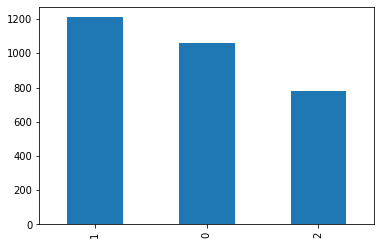

In [9]:
races = df['class'].value_counts()
print(races)
races.plot.bar()

So the most played class is Protoss. Either way, considering about 3000 games, and almost 1000 matchs per race in the case of Protoss and Zerg, we can say they are pretty used. But it seems it is not the same for Zerg.
And about players changing their race?

In [10]:
df.groupby(['class','id'])['id'].count()

class  id                                                         
0      http://eu.battle.net/sc2/en/profile/1173786/1/VPbenQsLivko/    12
       http://eu.battle.net/sc2/en/profile/2048063/1/AcerBly/         13
       http://eu.battle.net/sc2/en/profile/2101268/1/Stephano/        12
       http://eu.battle.net/sc2/en/profile/2115876/1/FireCake/        16
       http://eu.battle.net/sc2/en/profile/219517/1/TargA/             7
                                                                      ..
2      http://xx.battle.net/sc2/en/profile/405/1/MMA/                  4
       http://xx.battle.net/sc2/en/profile/406/1/INnoVation/           4
       http://xx.battle.net/sc2/en/profile/408/1/Polt/                 6
       http://xx.battle.net/sc2/en/profile/410/1/STBomber/            15
       http://xx.battle.net/sc2/en/profile/413/1/Maru/                15
Name: id, Length: 200, dtype: int64

Even though we can't see all matches, we can notice that there are only 200 different lines. And as we have 200 different players, it means there are no 2 classes with the same player!
So every gamer choose always the same race.

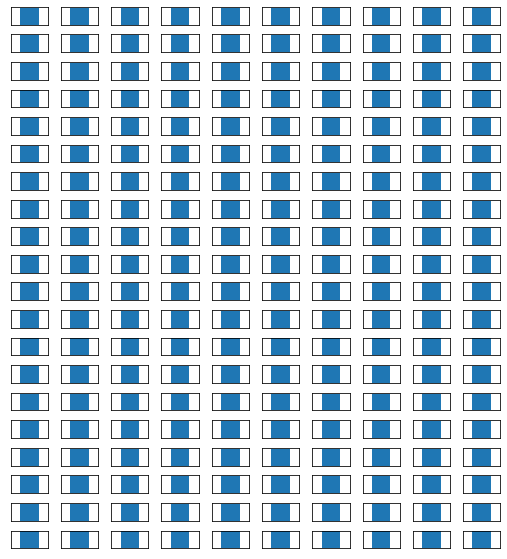

In [11]:
f,ax=plt.subplots(20,10,figsize=(8,8))
dfi = df.set_index("id")
nb_joueur_temp = copy.deepcopy(nb_joueur)
for x in range(0,20) :
    for y in range(0, 10):
        races_joueur = dfi.loc[nb_joueur_temp.pop()]['class'].value_counts()
        races_joueur.plot.bar(ax=ax[x, y])    
    
plt.subplots_adjust(top=0.98, bottom=0.04, left=0.10, right=0.95, hspace=0.55,
                    wspace=0.35)
#Get rid of tick to make show clearer
for row in ax:
    for col in row:
        col.set_xticks([])
        col.set_yticks([])

plt.show()  

Even though we got rid of labels in order to make it more clean, basically in x axis we have the race chosen, and in y we have the number of games played with each race, where each plot corresponds to one player. As we can see, each player only has one bar, which means that (as we saw above), the same player never uses two differents races.

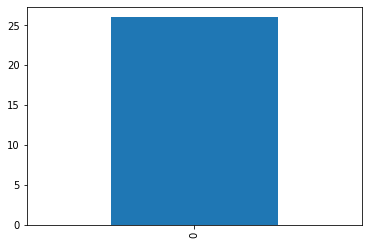

In [12]:
races_joueur = dfi.loc[ids[100]]['class'].value_counts()
races_joueur.plot.bar()

**Conclusion: Race feature is important.**

And what about the hotkeys used?

Check the variance of use of the hotkeys.

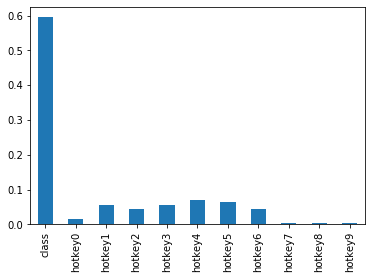

In [13]:
df.var().plot.bar()

It seems that hotkeys 8,9, 0 and 7 are always used the same way. However, we can not assume that these features could be deleted, as they are maybe used only by some specific players, which would be helpful to rapidly detect them.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd86638ee0>,
      dtype=object)

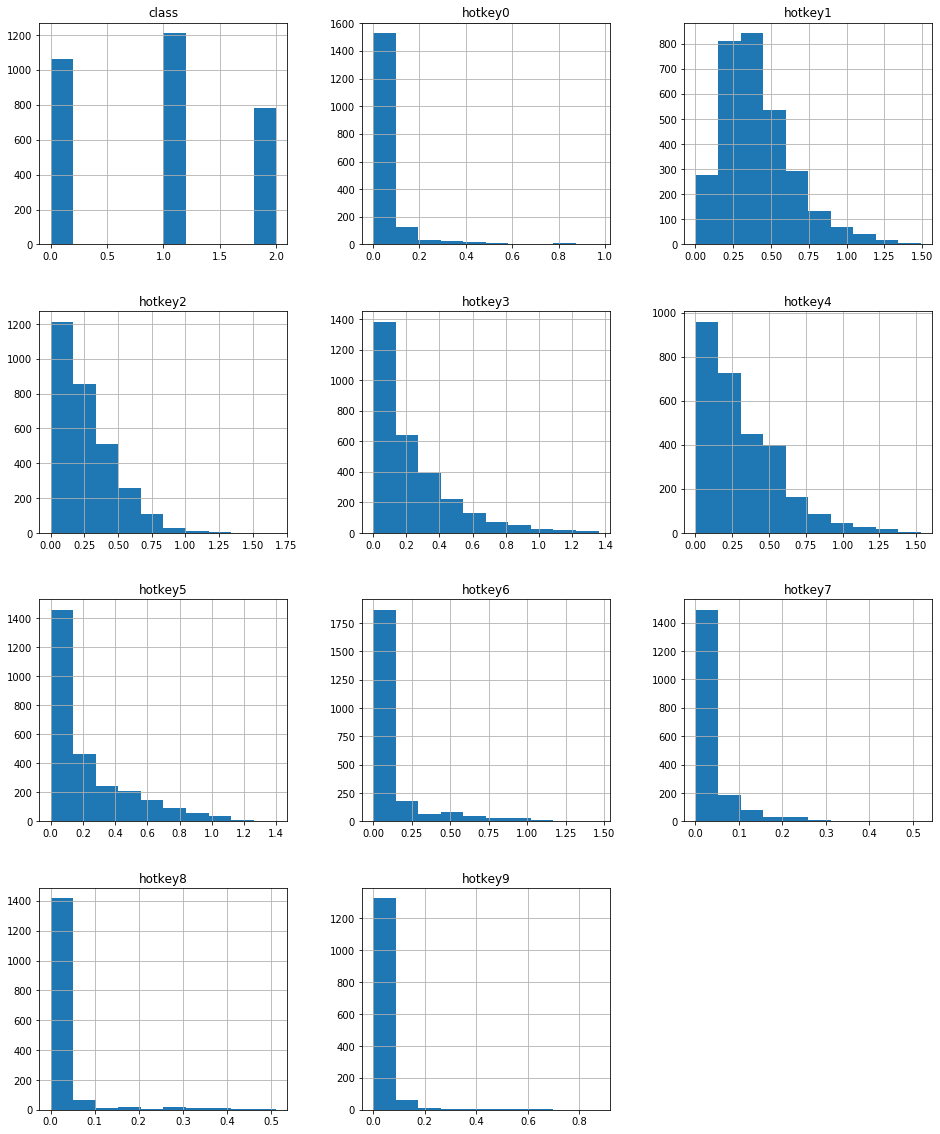

In [14]:
df.hist(figsize = (16,20), stacked= False)

By the figures above we can certify what we said above, hotkeys 9, 8, 7 and 0 merely vary in their frequency.

Now lets find if we can find some correlation between hotkeys.

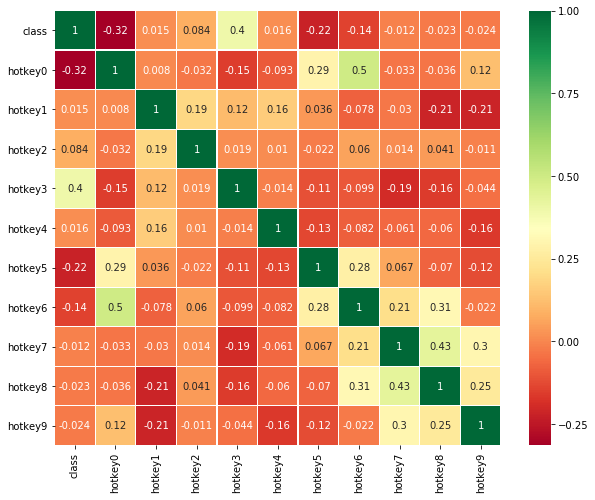

In [15]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

It seems that they are not too much correlated, so that it may be better to keep them all in order to not to loose information about the player.

# Models

Now we will test some models in these features.

## Prepare features

In [16]:
x, _ = get_train_data()
df_X = pd.DataFrame(x, columns=CSV_KEYS) 
df_X = df_X.drop(columns='id')
X = df_X.fillna(0).values
y = np.asarray(ids)
# Stratify data in train and valid, taking care of having each player at least one time in each sample
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                    stratify= ids, 
                                                    test_size=0.20)

#Overfit as there is not even repartition of matchs
smt = SMOTE(k_neighbors=1)
X_train, y_train = smt.fit_sample(X_train, y_train)

#Scale data, although it shouldn't be necessary because it is all in the range of 0-1 except from classes.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

## Choose some models

In [17]:
f1_scores = {}
# DESICION TREE

classifier = DecisionTreeClassifier(random_state=42)
classifier.fit(X_train,y_train)
y_predict = classifier.predict(X_valid)
f1_scores['decision_tree'] = f1_score(y_valid, y_predict, average='micro')

# Logistic Regression

classifier1 = LogisticRegression(random_state=0, solver='liblinear', multi_class='auto', max_iter=2000)
classifier1.fit(X_train,y_train)
y_predict1 = classifier1.predict(X_valid)
f1_scores['logistic regression'] = f1_score(y_valid, y_predict1, average='micro')

# Random forest

classifier2 = RandomForestClassifier(random_state=42, n_estimators=500)
classifier2.fit(X_train,y_train)
y_predict2 = classifier2.predict(X_valid)
f1_scores['random_forest'] = f1_score(y_valid, y_predict2, average='micro')

# KNN with K=3

classifier3 = KNeighborsClassifier(n_neighbors=3)
classifier3.fit(X, y)
y_predict3 = classifier3.predict(X_valid)
f1_scores['knn_k=3'] = f1_score(y_valid, y_predict3, average='micro')

In [18]:
#Show different f1s
for key, value in f1_scores.items():
    print('{:<32} {:<12}\n'.format(key, value))

decision_tree                    0.7414075286415713

logistic regression              0.7463175122749591

random_forest                    0.8756137479541735

knn_k=3                          0.2193126022913257

